In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from catboost import CatBoostClassifier


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve,roc_auc_score

from copy import copy

from itertools import accumulate

import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_txt(txt):
    df=pd.DataFrame()
    mydict = {'ev':[],'qop':[],'tx':[],'ty':[],'ismuon':[],'truth':[],'proton_truth':[],'pion_truth':[],'lambda_mother':[]}
    with open(txt,'rb') as file:
        lines = np.array(file.readlines())
    end = b'Cannot read more data (Header). End-of-File reached.\n'
    lines = np.delete(lines, np.where(lines == end))
    #lines = lines[:-2]
    factor = len(mydict.keys())
    n_lines = len(lines)
    n_iters = int(n_lines/factor)
    #print(n_iters)
    for i in range(n_iters):
        try:
            event = lines[int(factor*i):int(factor*i+factor)]
            #print(event)
            mydict['ev'].append(int(event[0].split()[2]))
            mydict['ismuon'].append(int(event[1].split()[2]))
            mydict['truth'].append(int(event[2].split()[2]))
            mydict['qop'].append(float(event[3].split()[3]))
            mydict['tx'].append(float(event[4].split()[3]))
            mydict['ty'].append(float(event[5].split()[3]))
            mydict['proton_truth'].append(float(event[6].split()[2]))
            mydict['pion_truth'].append(float(event[7].split()[2]))
            mydict['lambda_mother'].append(float(event[8].split()[2]))
        except:
            print('THis event failed:')
            print(event)
            raise
    df=pd.DataFrame().from_dict(mydict)
    #print(df['qop'])
    return df
        
        
def match_muons_ev(ev_truth,ev_reco):
    #ev_reco = ev_reco[['tx_velo','ty_velo','ev','qop']]
    true_df = pd.DataFrame()
    evs_t = np.unique(ev_truth['ev'])
    evs_r = np.unique(ev_reco['ev'])
    evs = evs_r[np.isin(evs_r,evs_t)]
    
    
    closevars = [
        #'qop',
        'tx','ty']
    closevars_t = [
        #'qop',
        'tx_velo','ty_velo']
    out_df = pd.DataFrame()
    for i_ev in evs_r:
        ev_truth_ev = ev_truth.query(f'ev == {i_ev}')
        ev_reco_ev = ev_reco.query(f'ev == {i_ev}')
        indices = -1*np.ones(len(ev_reco_ev))
        for i in range(len(ev_truth_ev)):
            row_t = ev_truth_ev.iloc[i]
            close = np.isclose(row_t[closevars].to_numpy(),ev_reco_ev[closevars_t].to_numpy(),rtol=0.005)
            index = np.asarray(np.sum(close,axis=1)==len(closevars)).nonzero()
            if len(index) and len(index[0]):
                index = index[0][0]
                if out_df.empty:
                    out_df = pd.DataFrame(ev_reco_ev.iloc[index]).transpose()
                else:
                    out_df = pd.concat([out_df, pd.DataFrame(ev_reco_ev.iloc[index]).transpose()])
                                                                    
                
            
    out_df.replace([np.nan, -np.inf,np.inf], 0,inplace=True)
    return out_df

def create_branches(df):
    df.eval('p=abs(qop)',inplace=True)
    df.eval('pt=sqrt((tx_velo**2+ty_velo**2)/(1+tx_velo**2+ty_velo**2))*p',inplace=True)
    df.eval('dtx=abs(tx_scifi-tx_muon)',inplace=True)
    df.eval('dty=abs(ty_scifi-ty_muon)',inplace=True)
    
    df.eval('dtx_refit=abs(tx_scifi-tx_refit)',inplace=True)
    df.eval('dty_refit=abs(ty_scifi-ty_refit)',inplace=True)
    
    df.fillna(0)
    
    return df






In [3]:
root = '/Users/adriancasaisvidal/storage/muonid/'
root_mit = '/data/submit/lhcb/muonid/'
df_truth = read_txt(root + 'monitoring-muons.txt').query('truth==1 and ismuon==1').reset_index(drop=True)
bkg = 'proton'
df_protons =read_txt(root + 'monitoring-bulambda.txt').query(f'{bkg}_truth==1 and ismuon==1 and lambda_mother==1').reset_index(drop=True)
df_protons.eval(f'truth={bkg}_truth',inplace=True)
df_r = ur.open(root + f'monitoring-muons.root:is_muon_594572e9/monitor_tree').arrays(library='pd')
df_r_protons = ur.open(root + f'monitoring-bulambda.root:is_muon_594572e9/monitor_tree').arrays(library='pd')
df_true = match_muons_ev(df_truth,df_r)
df_false = match_muons_ev(df_protons,df_r_protons,)
df_true,df_false = create_branches(df_true),create_branches(df_false)

In [4]:
from random import random 
df_true.query('pt<4000 and p < 40000',inplace=True),df_false.query('pt<4000 and p < 40000',inplace=True)
n_true = df_true.shape[0]
n_false = df_false.shape[0]
print(n_true,n_false)

2326 1993


In [5]:
def chi2_corr(df,prefix=''):
    def covij(i,j,p):
            if i>j:
                i,j=j,i
            val = 0
            higher = j+1
            if p< 6000:
                higher = min(j+1,4)
            for l in range(higher):
                val += (z_m[i]-absorb[l][0])*(z_m[j]-absorb[l][0])*13.6**2*absorb[l][1]
            return val/p**2
    absorb = [[12800,25],   #ECAL
              [14300,53],   #HCAL
              [15800,47.5], #M2
              [17100,47.5], #M3
              [18300,47.5]] #M4
    
    for i in range(4):
        df.eval(f'{prefix}xs{i}= {prefix}tx_scifi*{prefix}z{i} + {prefix}ax_scifi',inplace=True)
        df.eval(f'{prefix}ys{i}= {prefix}ty_scifi*{prefix}z{i} + {prefix}ay_scifi',inplace=True)
    #df[f'{prefix}chi2corr']=0
    chi2corr_a=[]
    chi2uncorr_a = []
    no_hits = []
    for _,r in df.iterrows():
        x_m = np.array([r[f'{prefix}x0'],r[f'{prefix}x1'],r[f'{prefix}x2'],r[f'{prefix}x3']])
        y_m = np.array([r[f'{prefix}y0'],r[f'{prefix}y1'],r[f'{prefix}y2'],r[f'{prefix}y3']])
        z_m = np.array([r[f'{prefix}z0'],r[f'{prefix}z1'],r[f'{prefix}z2'],r[f'{prefix}z3']])
        
        padx = 2*np.array([r[f'{prefix}dx0'],r[f'{prefix}dx1'],r[f'{prefix}dx2'],r[f'{prefix}dx3']])
        pady = 2*np.array([r[f'{prefix}dy0'],r[f'{prefix}dy1'],r[f'{prefix}dy2'],r[f'{prefix}dy3']])
        
        x_s = np.array([r[f'{prefix}xs0'],r[f'{prefix}xs1'],r[f'{prefix}xs2'],r[f'{prefix}xs3']])
        y_s = np.array([r[f'{prefix}ys0'],r[f'{prefix}ys1'],r[f'{prefix}ys2'],r[f'{prefix}ys3']])
        mask = x_m != -99999

        no_hits.append(np.sum(mask))
        x_m = x_m[mask]
        y_m = y_m[mask]
        padx = padx[mask]
        pady = pady[mask]
                           
        x_s = x_s[mask]
        y_s = y_s[mask]
        
        dx = x_m - x_s
        dy = y_m - y_s
        
        s = len(x_m)
        cov = np.zeros((s,s))
        # for i_station in range(4):
        #     for j_station in range(i_station+1):
        #         if i_station == j_station:
        #             continue
        #         cov[i_station,j_station]= list(
        #             accumulate(absorb[0:j_station+2],initial=0,
        #             func=lambda init,c: 
        #                 init+(z_m[i_station]-c[0])*(z_m[j_station]-c[0])*13.6**2*c[1]))[-1]/(r['p'])**2
        #         cov[j_station,i_station]=cov[i_station,j_station]
        
        
        
        
            
        for i_station in range(s):
            for j_station in range(i_station+1):
                    cov[i_station,j_station]=covij(i_station,j_station,np.abs(r[f'{prefix}p']))
                    cov[j_station,i_station]=covij(i_station,j_station,np.abs(r[f'{prefix}p']))
                
        covx = cov
        covy = copy(covx)
        
        covxuncorr = np.zeros((s,s))
        covyuncorr = np.zeros((s,s))
        for i in range(s):
                covx[i,i] += (padx[i]/np.sqrt(12))**2
                covxuncorr[i,i] += (padx[i]/np.sqrt(12))**2
                covy[i,i] += (pady[i]/np.sqrt(12))**2
                covyuncorr[i,i] += (pady[i]/np.sqrt(12))**2
            
        
        resx = np.all(np.linalg.eigvals(covx) > 0)
        resy = np.all(np.linalg.eigvals(covy) > 0)
        
        if not (resx and resy):
            #print(f'Matrix x is {resx} PD. Matrix y is {resy} PD')
            pass
        chi2uncorr = (dx @ np.linalg.inv(covxuncorr) @ dx + dy @ np.linalg.inv(covyuncorr) @ dy)/s
        

        
        chi2corrx  = dx @ np.linalg.inv(covx) @ dx
        chi2corry = dy @ np.linalg.inv(covy) @ dy
        chi2corr = (chi2corrx + chi2corry)/s
            
        
            
        
        
        
        chi2corr_a.append(chi2corr)
        chi2uncorr_a.append(chi2uncorr)
        # print(dx)
        # print(chi2corr)
        # print(x_m)
        
    df[f'{prefix}chi2corr']=np.log10(np.abs(chi2corr_a))
    df[f'{prefix}chi2uncorr']=np.log10(np.abs(chi2uncorr_a))
    df[f'{prefix}no_hits'] = no_hits
    return df

In [6]:
df_true = chi2_corr(df_true).dropna()
df_false = chi2_corr(df_false).dropna()
eff_true = df_true.shape[0]/n_true
eff_false = df_false.shape[0]/n_false
print(eff_true)
print(eff_false)

1.0
1.0


In [7]:
def get_training_data(signal_df,background_df,bdt_vars):
    signal_df["category"]= 1 #Use 1 for signal
    background_df["category"] = 0 #use 0 for bkg
    training_data = pd.concat([signal_df[bdt_vars+['category']],background_df[bdt_vars+['category']]],copy=True,ignore_index=True,sort=False)
    training_data=training_data.sample(frac=1).reset_index(drop=True)
    training_data = training_data.dropna()

    return training_data
def kfold(x,y,scores=True,bdt=xgb.XGBClassifier,args={'eta':0.2,
                                                      'objective':'binary:logistic',
                                                      'n_estimators':200,
                                                      'max_depth':10,
                                                     },splits=5):
    kf = KFold(n_splits=splits)
    _,counts =np.unique(y,return_counts=True)
    if scores:
        score_bdt = copy(bdt)(**args)
        scores = cross_val_score(score_bdt,x,y,cv=kf)
    print(5*"#")
    print("Cross validation scores:")
    print(scores)
    print(5*"#")
    classifiers = []
    for tri,tti in kf.split(x):
        x_train,y_train = x.iloc[tri],y.iloc[tri]
        classifiers.append(copy(bdt)(**args))
        classifiers[-1].fit(x_train,y_train)
    return classifiers

def train_and_test(bdt,args,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    bdt = bdt(**args)
    bdt.fit(X_train,y_train)
    sig_test = bdt.predict_proba(X_test[np.array(y_test,dtype='bool')])[:,1]
    bkg_test = bdt.predict_proba(X_test[~np.array(y_test,dtype='bool')])[:,1]
    
    sig_train = bdt.predict_proba(X_train[np.array(y_train,dtype='bool')])[:,1]
    bkg_train = bdt.predict_proba(X_train[~np.array(y_train,dtype='bool')])[:,1]
    
    plt.hist(sig_test,bins=50,density=True,label='Signal test',color='blue',alpha=0.6)
    plt.hist(bkg_test,bins=50,density=True,label='Background test',color='red',alpha=0.6)
    
    plt.hist(sig_train,bins=50,density=True,label='Signal train',color='blue',histtype='step',alpha=0.6)
    plt.hist(bkg_train,bins=50,density=True,label='Background train',color='red',histtype='step',alpha=0.6)
    plt.legend()
    plt.savefig('overtraining.png')
    plt.show()
    return [bdt]
    
    
def performance_test(x,y,bdts):
    fig,ax = plt.subplots(1,1)
    sig = np.zeros(len(x[np.array(y,dtype='bool')]))
    bkg = np.zeros(len(x[~np.array(y,dtype='bool')]))
    for bdt in bdts:
        sig += bdt.predict_proba(x[np.array(y,dtype='bool')])[:,1]/len(bdts)
        bkg += bdt.predict_proba(x[~np.array(y,dtype='bool')])[:,1]/len(bdts)
    ax.hist(sig,bins=50,density=True,label='Signal',alpha=0.7)
    ax.hist(bkg,bins=50,color='red',density=True,label='Background',alpha=0.7)
    ax.set_xlabel(r'Classifier output')
    ax.set_ylabel('A.U.')
    ax.legend()
    #fig.savefig("overtraining.pdf")
    #return [bdt]
    
def make_roc_curve(x,y,bdts,mytype='xgb'):
    fig,ax = plt.subplots(1,1)
    
    proba = np.zeros(len(x))
    for bdt in bdts:
        proba += bdt.predict_proba(x)[:,1]/len(bdts)
    fpr,tpr,_ = roc_curve(y,proba)
    ax.plot(fpr,tpr,label = f'{mytype}')
    ax.legend()
    score = roc_auc_score(y,proba)
    print(f'ROC AUC: {score}') 
    plt.savefig('roc.png')
def make_var_roc_curve(df,input_vars,y):
    fig,ax = plt.subplots(1,1)
    for var in input_vars:
        fpr,tpr,_ = roc_curve(y,-df[var])
        ax.plot(fpr,tpr,label = f'{var}')
        score = roc_auc_score(y,-df[var])
        print(f'ROC AUC {var}: {score}') 
    ax.legend()
    
    plt.savefig(f'roc-{var}.png')
    plt.legend()
    

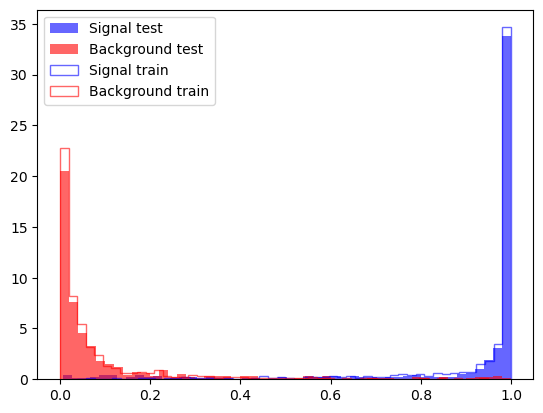

#####
Cross validation scores:
[0.92847222 0.92222222 0.91869354]
#####
ROC AUC: 0.9904379429464863
ROC AUC chi2corr: 0.9302086537619414
ROC AUC chi2uncorr: 0.95426080706376
ROC AUC chi2x: 0.8707611204995643
ROC AUC chi2y: 0.8691959907828732
ROC AUC dtx: 0.824173515300111
ROC AUC dty: 0.8275596142819731
ROC AUC extrapol_dist: 0.8066236988531226
ROC AUC dt0: 0.6988334924600675
ROC AUC t0: 0.5097421801757569


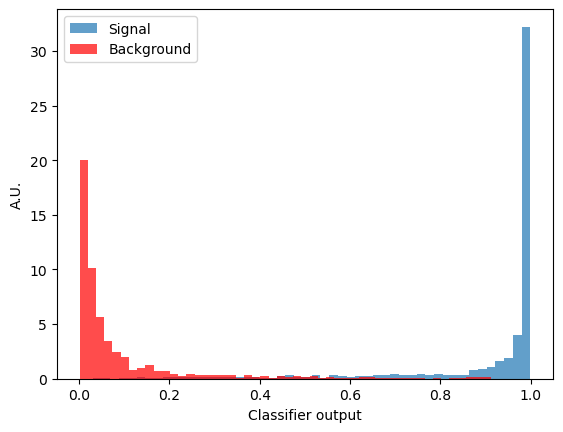

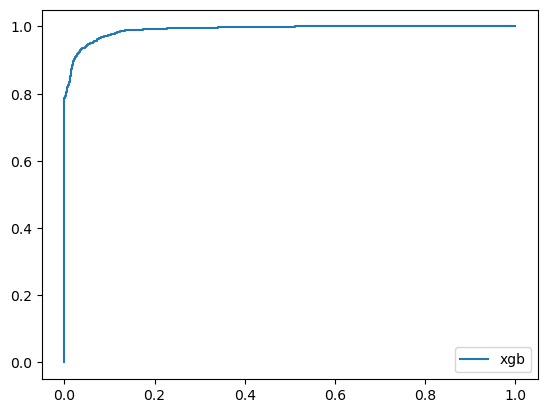

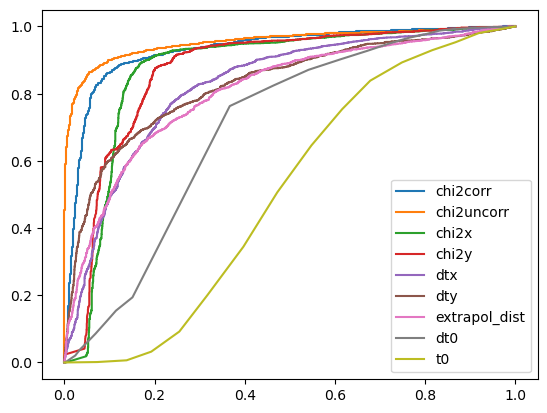

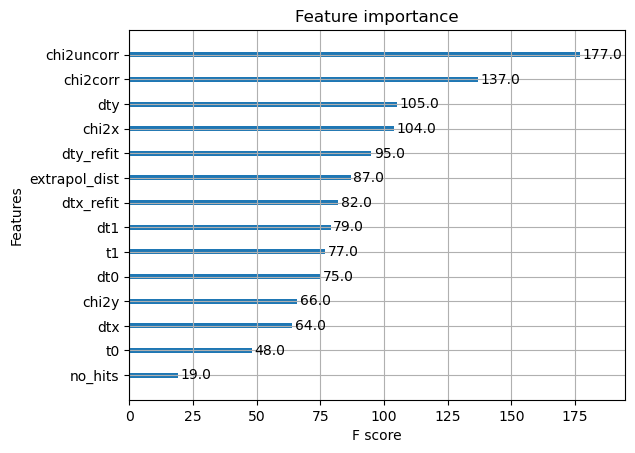

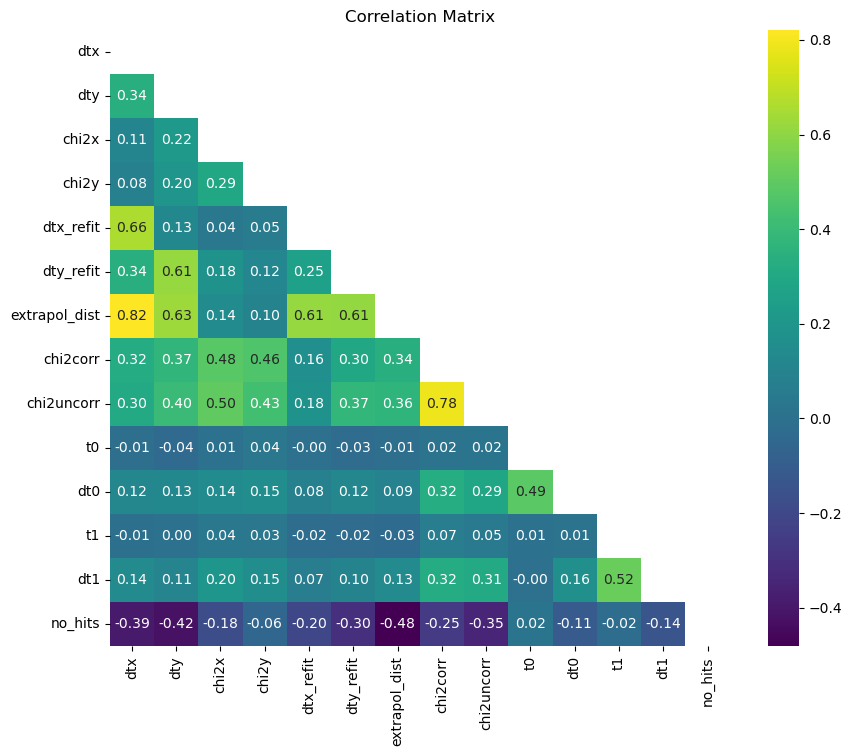

In [8]:
features = [
            'dtx',
            'dty',
            'chi2x',
            'chi2y',
            'dtx_refit',
            'dty_refit',
            'extrapol_dist',
            #'occ2',
            #'occ3',
            #'occ4',
            #'occ5',
            'chi2corr',
            'chi2uncorr',
            't0',
            'dt0',
            't1',
            'dt1',
            # 't2',
            # 'dt2',
            # 't3',
            #'dt3',
            'no_hits',
            #'p',
            #'pt',
            #'tx_velo',
            #'ty_velo',
           ]

training_data = get_training_data(df_true,df_false,features)
x,y=training_data[features],training_data['category']
mybdt= xgb.XGBClassifier
#mybdt = AdaBoostClassifier
#mybdt = CatBoostClassifier
myargs = {
         #'eta':0.01,
        'learning_rate':0.07,
          #'silent':True,
        'objective':'binary:logistic',
        #'objective':'binary:hinge',
        'n_estimators':200,
        'max_depth':3,
        'scale_pos_weight':1.*df_false.shape[0]/df_true.shape[0],
        'random_state':1134,
           }

bdts = train_and_test(mybdt,myargs,x,y)
bdts = kfold(x,y,bdt=mybdt,scores=True,
             args=myargs,splits=3
            )

with open('muon_bdt.pkl', 'wb') as handle:
    pickle.dump([features,bdts],handle)
performance_test(x,y,bdts)
make_roc_curve(x,y,bdts)
make_var_roc_curve(x,['chi2corr',
                      
                      'chi2uncorr',
                      'chi2x','chi2y','dtx','dty',
                      #'dtx_refit',
                      #'dty_refit',
                      'extrapol_dist',
                      #'no_hits',
                      #'occ2','occ3','occ4','occ5',
                      'dt0','t0'],y)


xgb.plot_importance(bdts[0])
import seaborn as sns
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(training_data[features].corr(), dtype=bool))
sns.heatmap(training_data[features].corr(), annot=True, cmap='viridis', mask=mask, fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('corr_matrix.png')

In [9]:
df_true['bdt'] = np.zeros(len(df_true))
df_false['bdt'] = np.zeros(len(df_false))
for bdt in bdts:
    df_true['bdt']  += bdt.predict_proba(df_true[features])[:,1]/len(bdts)
    df_false['bdt'] += bdt.predict_proba(df_false[features])[:,1]/len(bdts)
cut = 0.8
eff = 1.*df_true.query(f'bdt>{cut}').shape[0]/df_true.shape[0]*eff_true
bkg_rej = 1 - df_false.query(f'bdt>{cut}').shape[0]/df_false.shape[0]*eff_false

print(f'Signal efficiency: {eff}, True muons: {eff*df_true.shape[0]}')
print(f'Bkg rejection: {bkg_rej}, False muons: {(1-bkg_rej)*df_false.shape[0]}')

Signal efficiency: 0.8456577815993122, True muons: 1967.0
Bkg rejection: 0.9874560963371801, False muons: 25.000000000000014


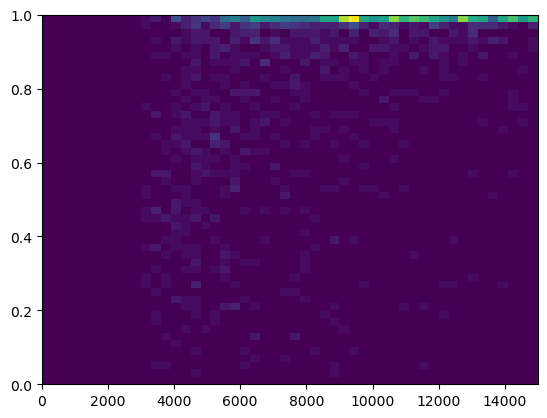

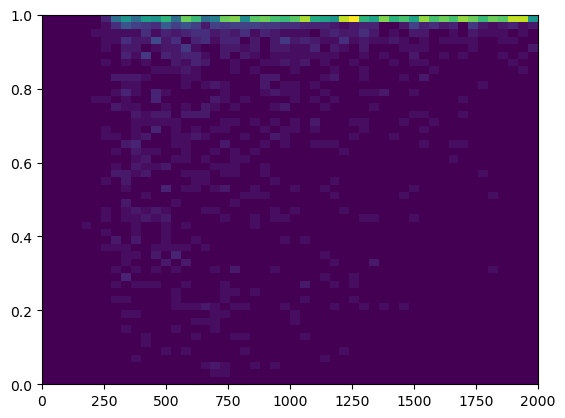

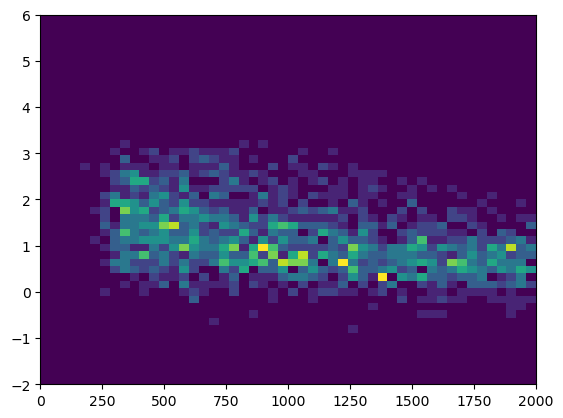

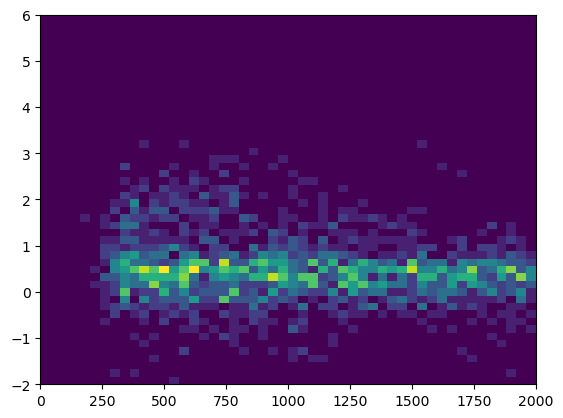

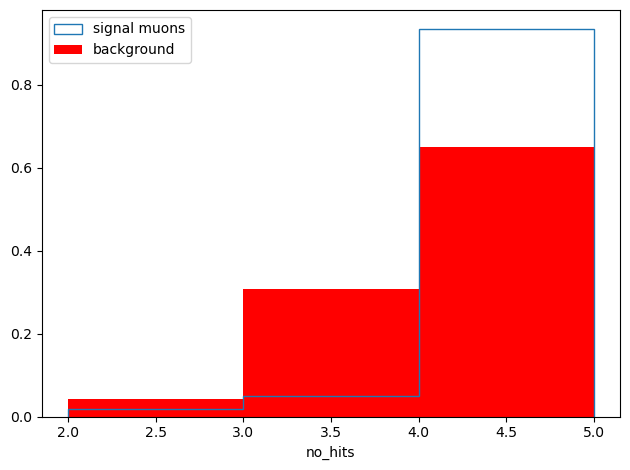

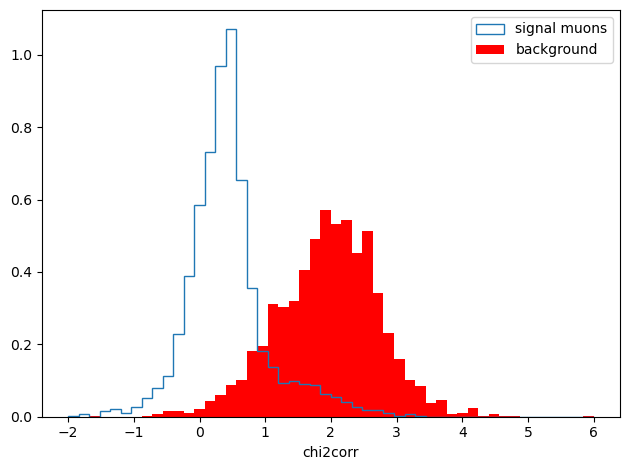

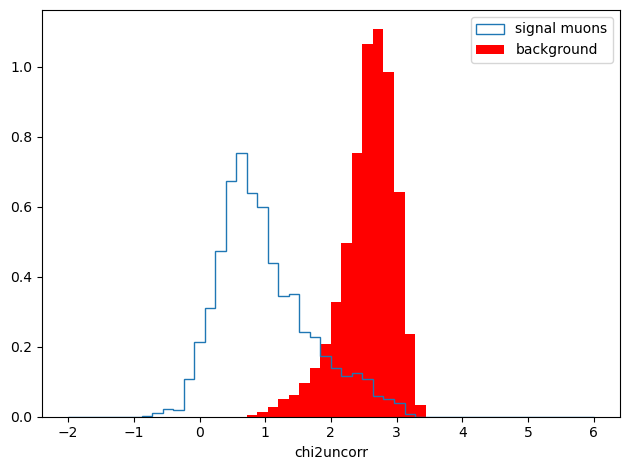

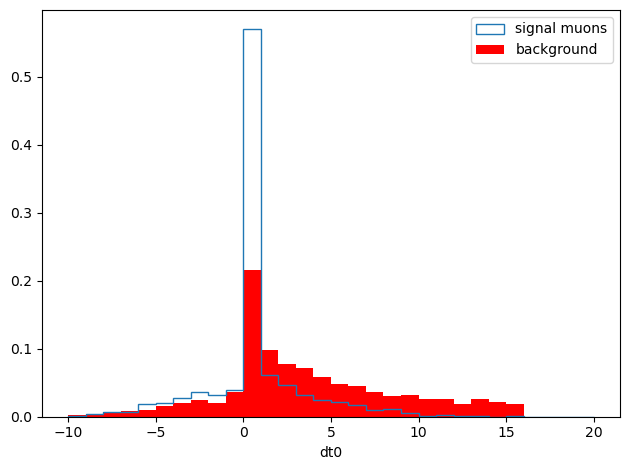

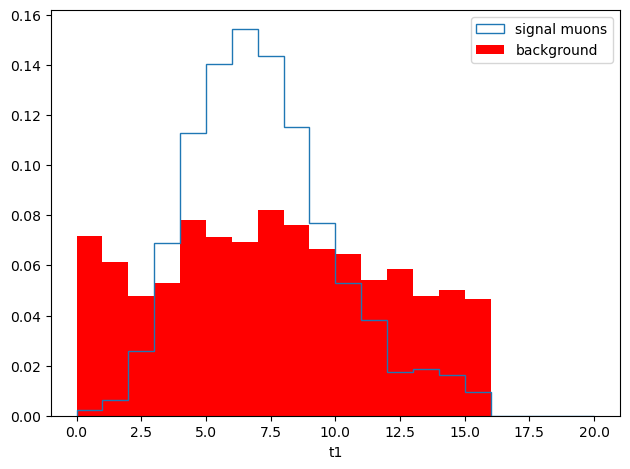

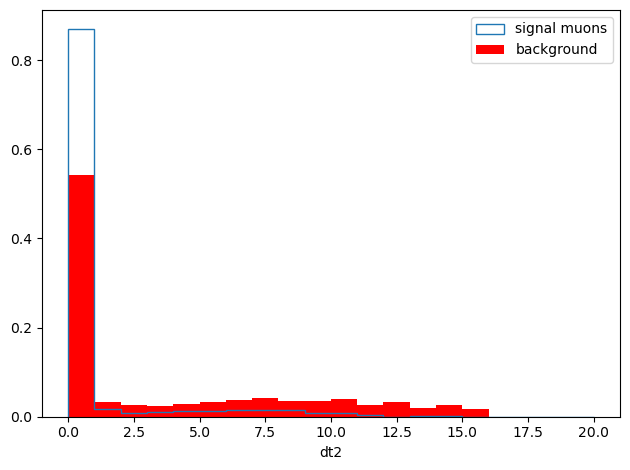

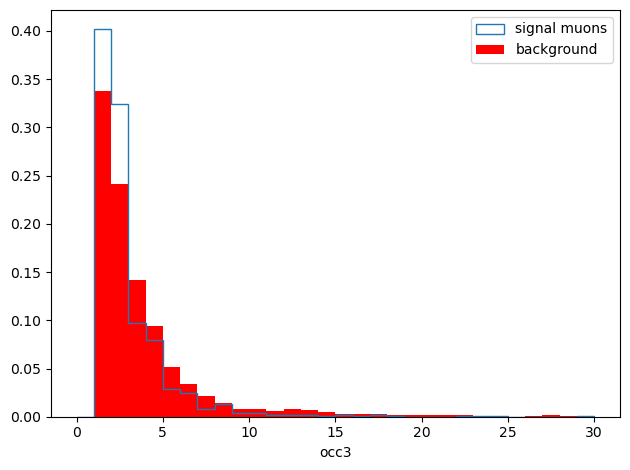

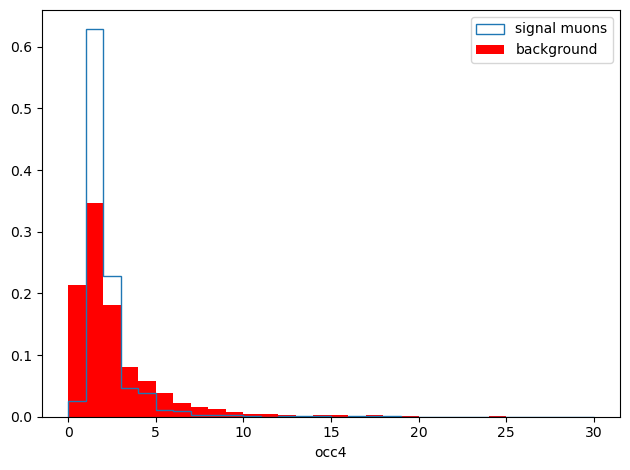

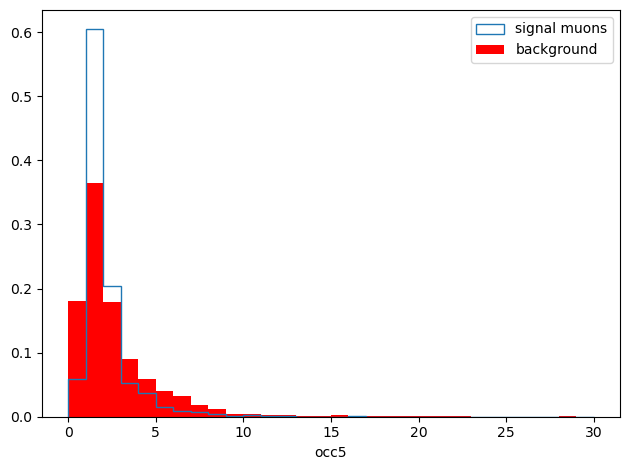

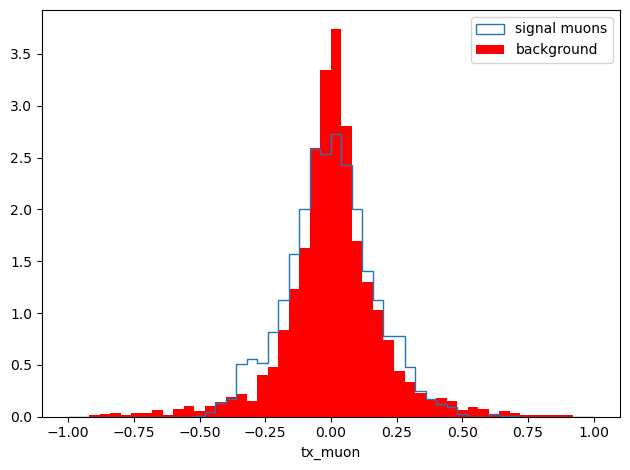

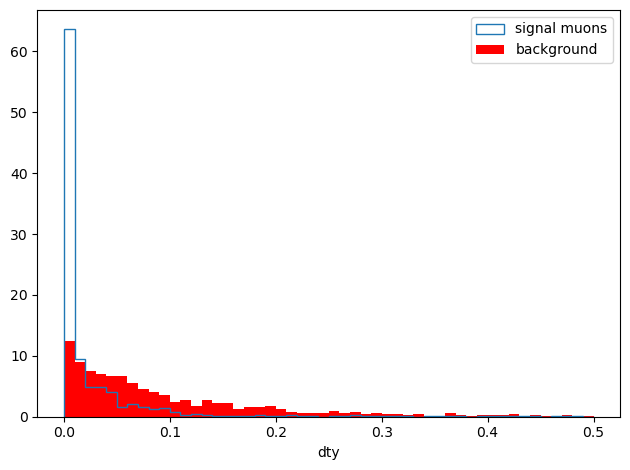

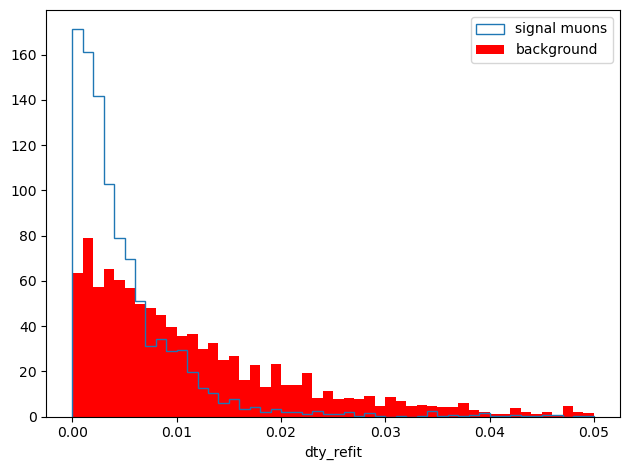

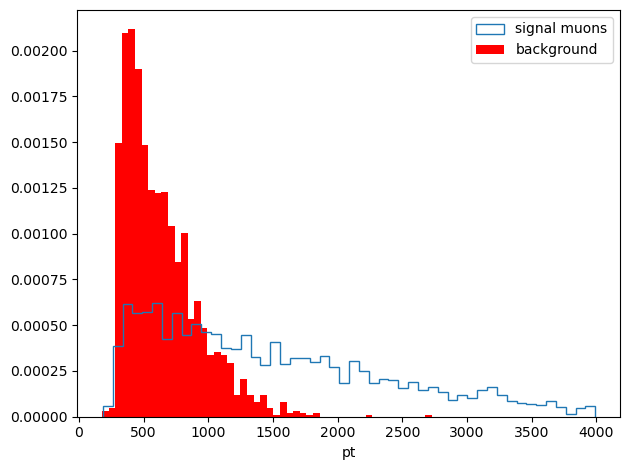

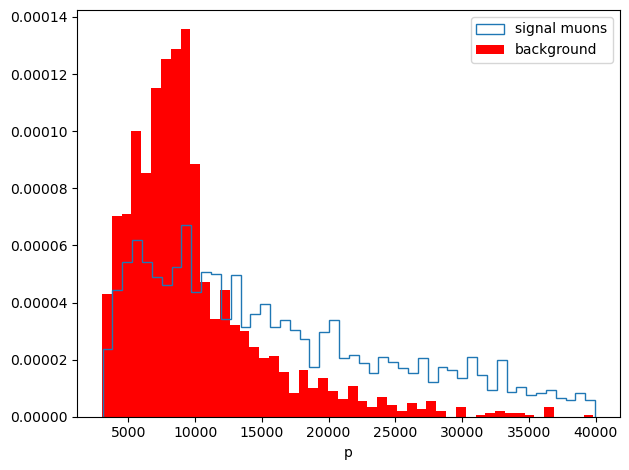

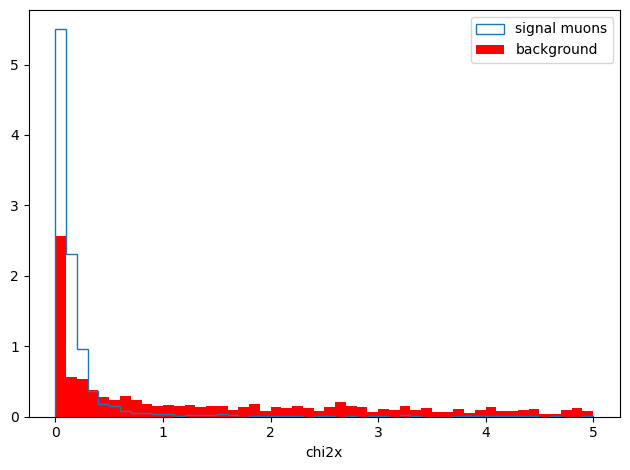

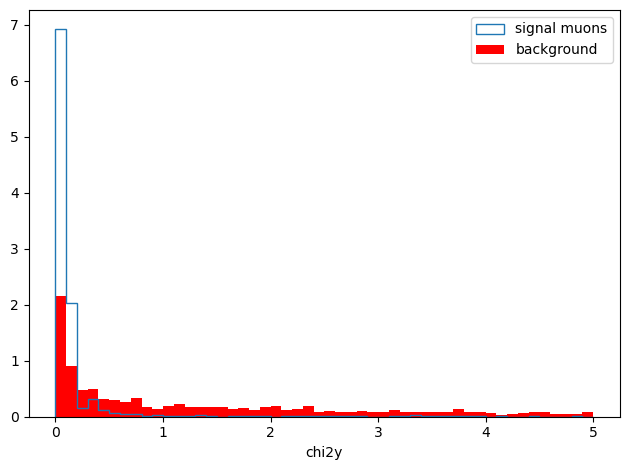

In [10]:
def compare_plot(df_s,df_b,var,w=None,discrete=False):
    if w == None or type(w)==tuple:
        myrange = w
    else:
        myrange = (-w,w)
    nbins=50
    if discrete:
        nbins=myrange[1]-myrange[0]
    plt.hist(df_s[var],bins=nbins,density=True,range=myrange,histtype='step',label='signal muons')
    plt.hist(df_b[var],bins=nbins,density=True,range=myrange,label='background',color='red')
    plt.xlabel(var)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'distributions/{var}.png')
    plt.show()
    
def hist2d(var1,var2,df,myrange=[[0,15000],[-5,5]]):
    plt.hist2d(df_true[var1],df_true[var2],bins=50,range=myrange)
    plt.show()
# hist2d('qop','chi2corr',df_true,[[-10e3,10e3],[-10,10]])

hist2d('p','bdt',df_true,[[0,15000],[0,1]])
hist2d('pt','bdt',df_true,[[0,2000],[0,1]])

hist2d('pt','chi2uncorr',df_true,[[0,2000],[-2,6]])
hist2d('pt','chi2corr',df_true,[[0,2000],[-2,6]])

# hist2d('tx_velo','chi2corr',df_true,[[0,2000],[0,300]])
compare_plot(df_true,df_false,'no_hits',(2,5),discrete=True)
compare_plot(df_true,df_false,'chi2corr',(-2,6))
compare_plot(df_true,df_false,'chi2uncorr',(-2,6))

compare_plot(df_true,df_false,'dt0',(-10,20),discrete=True)
compare_plot(df_true,df_false,'t0',(-10,20),discrete=True)    
compare_plot(df_true,df_false,'dt1',(0,20),discrete=True)
compare_plot(df_true,df_false,'t1',(0,20),discrete=True)
compare_plot(df_true,df_false,'dt2',(0,20),discrete=True)
compare_plot(df_true,df_false,'t2',(0,20),discrete=True)  
compare_plot(df_true,df_false,'extrapol_dist',(0,2000))
compare_plot(df_true,df_false,'occ2',(0,30),discrete=True)
compare_plot(df_true,df_false,'occ3',(0,30),discrete=True)
compare_plot(df_true,df_false,'occ4',(0,30),discrete=True)
compare_plot(df_true,df_false,'occ5',(0,30),discrete=True)
compare_plot(df_true,df_false,'tx_muon',1)
compare_plot(df_true,df_false,'dtx',(0,0.5))
compare_plot(df_true,df_false,'dty',(0,0.5))
compare_plot(df_true,df_false,'dtx_refit',(0,0.05))
compare_plot(df_true,df_false,'dty_refit',(0,0.05))
compare_plot(df_true,df_false,'pt',None)
compare_plot(df_true,df_false,'p',None)
compare_plot(df_true,df_false,'chi2x',(0,5))
compare_plot(df_true,df_false,'chi2y',(0,5))

In [11]:
U,S,Vh = np.linalg.svd(np.matrix([[2,0,2],[0,0,0],[2,0,2]]),full_matrices=True)

In [12]:
U@np.diag(S)@Vh

matrix([[2., 0., 2.],
        [0., 0., 0.],
        [2., 0., 2.]])